In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import os
import re
import string
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.optimize as so
# import sympy as sym
# sym.init_printing(use_unicode=False, wrap_line=True)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
# データの読み込み
df = pd.read_csv("./data/wholetime.csv")
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [6]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [7]:
active_node_list, edge_list, timestamp = return_nm(df)

In [ ]:
# データセットをいくつかのグループに分ける
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')]
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')]
df_p3 = df[(df['started_at'] >= '2020-11-01') & (df['started_at'] < '2021-03-01')]
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')]

node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)


In [ ]:
node_list = [node_list_p1, node_list_p2, node_list_p3, node_list_p4]
node_list = max(node_list, key=len)

nn = len(node_list)
xmin = min(node_list)
xmax = max(node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(20, 10))
plt.scatter(node_list_p1, edge_list_p1, label='2020/4~2020/5')
plt.scatter(node_list_p2, edge_list_p2, label='2020/6~2020/10')
plt.scatter(node_list_p3, edge_list_p3, label='2020/11~2021/2')
plt.scatter(node_list_p4, edge_list_p4, label='2021/3~2023/10')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [8]:
def model1(m, m0, kappa):
    Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    if res.any() < 0:
        return 0
    else:
        return res

In [9]:
def model2(m, m0, Np):
    kappa = 8*m0/(Np**2-Np)
    res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
    if res.any() < 0:
        return 0
    else:
        return res

In [10]:
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

In [11]:
def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [12]:
# 初期値を探す for model1
# 初期値の範囲を設定
init_m0_range = [1, 1000]
init_kappa_range = [0.001, 1]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list, active_node_list, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = active_node_list - model1(edge_list, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]


[2.04481017e+03 3.84369474e-02]


In [13]:
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [2, 1000]
init_Np_range = [1, 1000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model1, edge_list, active_node_list, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = active_node_list - model2(edge_list, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[685.97365172 858.60117064]


In [14]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list,active_node_list,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list)):
    Np.append((1+np.sqrt(1+32*edge_list[i]/kappa))/2)


for i in range(len(active_node_list)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list)):
    M_fit.append(calc_M(Np[i], kappa))



N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, edge_list, active_node_list, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_list)):
    kappa2.append(8*edge_list[i]/(Np2**2-Np2))

for i in range(len(active_node_list)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model1:  [2.04481017e+03 3.84369474e-02]
model2:  [677.90349444 864.01486569]


In [20]:
# model1とmodel2の残差を計算
residuals1 = active_node_list - N_fit
residuals2 = active_node_list - N_fit2

# 残差の転置を計算
residuals1_t = residuals1.T
residuals2_t = residuals2.T

if (residuals1_t*residuals1).any() < (residuals2_t*residuals2).any():
    print("model1 is better")
else:
    print("model2 is better")

model2 is better


In [19]:
print("model1の残差: ", residuals1)
print("model2の残差: ", residuals2)

model1の残差:  [ -192.29919669  -216.94150154  -320.37614262 ... -1414.31323732
 -1459.77146355 -1644.61411433]
model2の残差:  [-335.71953672 -324.48246124 -326.17631532 ... -160.70540602 -143.17277161
 -153.27975411]


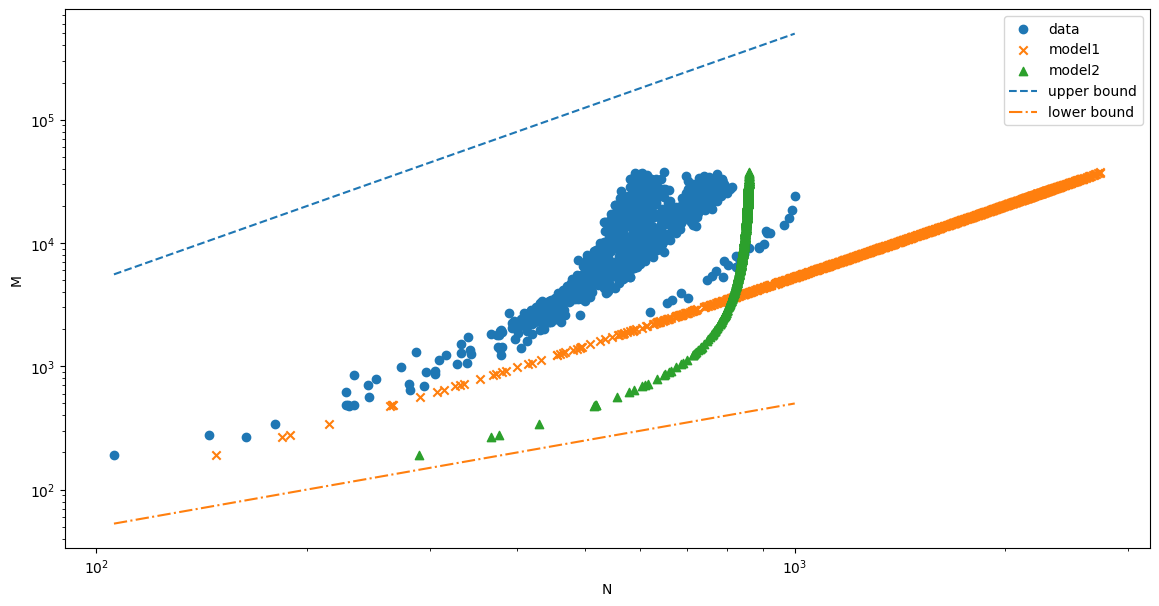

In [15]:
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(active_node_list, edge_list, label='data')
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

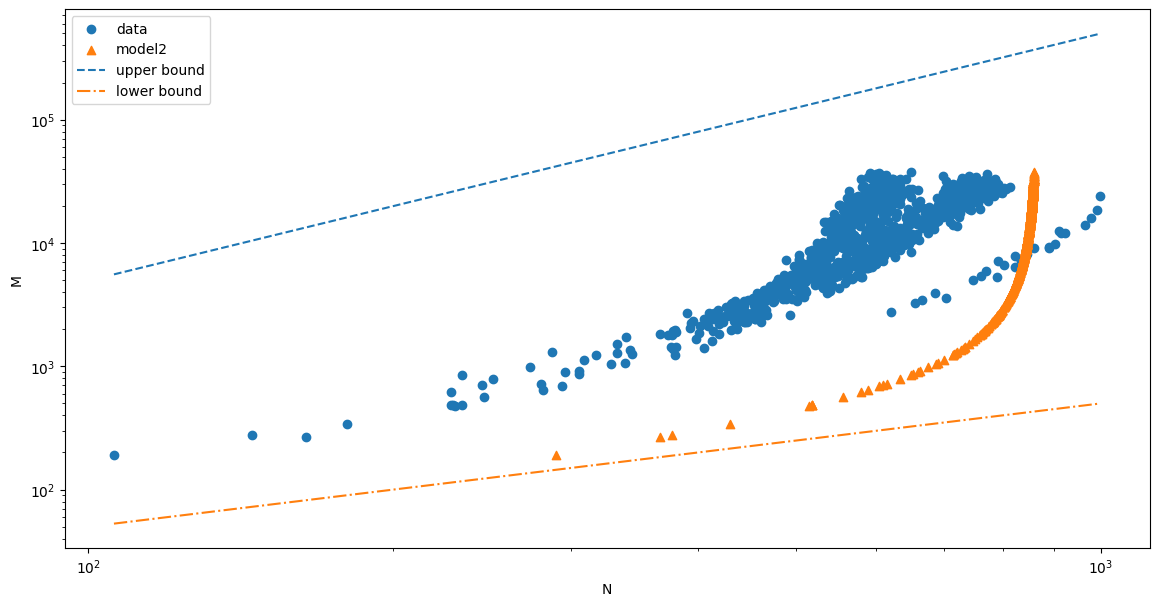

In [18]:
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(active_node_list, edge_list, label='data')
# plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# modell2からフィッティング
node_fit = np.linspace(0, 1276, 1276)
edge_fit = model2(node_fit, *popt)
plt.figure(figsize=(14, 7))
plt.scatter(active_node_list_sample, edge_list_sample, label='data')
plt.scatter(N_fit, M_fit, label='model2')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# Get the node_list, edge_list and timestamp
active_node_list_sample, edge_list_sample, timestamp_sample = return_nm(df_sample)

# プロット
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(active_node_list_sample, edge_list_sample, label='sampling')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [5]:
N = Np*(1-(2/(kappa*Np))*(1-(1-(kappa/2))**Np))
M = (Np**2-Np)*kappa/8

NameError: name 'Np' is not defined

# データの範囲を全体に広げてコードを書く

In [ ]:
df.head()

In [ ]:
active_node_list
edge_list
timestamp

In [ ]:
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(active_node_list, edge_list)
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
popt, pcov = curve_fit(model1,edge_list,active_node_list, [2, 0.001])
print(popt)

Np_model1 = []
for i in range(len(edge_list_sample)):
    Np_model1.append((1+np.sqrt(1+32*edge_list_sample[i]/popt[1]))/2)

In [ ]:
N_fit1 = []
M_fit1 = []
kappa1 = 5.73980165e-07

for i in range(len(active_node_list)):
    N_fit1.append(calc_N(Np_model1[i], kappa1))

for i in range(len(edge_list)):
    M_fit1.append(calc_M(Np_model1[i], kappa1))

In [ ]:
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(active_node_list, edge_list)
plt.scatter(N_fit1, M_fit1, label='fit')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

popt, pcov = curve_fit(model2, active_node_list, edge_list, [100, 1000])
Np = popt[1]
kappa = []
for i in range(len(edge_list)):
    kappa.append(8*edge_list[i]/(Np**2-Np))

N_fit2 = []
M_fit2 = []

for i in range(len(active_node_list)):
    N_fit2.append(calc_N(Np, kappa[i]))

for j in range(len(edge_list)):
    M_fit2.append(calc_M(Np, kappa[j]))


plt.figure(figsize=(14, 7))
plt.scatter(active_node_list, edge_list)
plt.scatter(N_fit2, M_fit2, label='fit')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.show()


# データ分割と考察

In [22]:
# データセットをいくつかのグループに分ける
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')]
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')]
df_p3 = df[(df['started_at'] >= '2020-11-01') & (df['started_at'] < '2021-03-01')]
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')]

node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)

In [119]:
# df_p4を月単位に分割
df_p4_1 = df_p4[(df_p4['started_at'] >= '2021-03-01') & (df_p4['started_at'] < '2021-04-01')]
df_p4_2 = df_p4[(df_p4['started_at'] >= '2021-04-01') & (df_p4['started_at'] < '2021-05-01')]
df_p4_3 = df_p4[(df_p4['started_at'] >= '2021-05-01') & (df_p4['started_at'] < '2021-06-01')]
df_p4_4 = df_p4[(df_p4['started_at'] >= '2021-06-01') & (df_p4['started_at'] < '2021-07-01')]
df_p4_5 = df_p4[(df_p4['started_at'] >= '2021-07-01') & (df_p4['started_at'] < '2021-08-01')]
df_p4_6 = df_p4[(df_p4['started_at'] >= '2021-08-01') & (df_p4['started_at'] < '2021-09-01')]
df_p4_7 = df_p4[(df_p4['started_at'] >= '2021-09-01') & (df_p4['started_at'] < '2021-10-01')]
df_p4_8 = df_p4[(df_p4['started_at'] >= '2021-10-01') & (df_p4['started_at'] < '2021-11-01')]
df_p4_9 = df_p4[(df_p4['started_at'] >= '2021-11-01') & (df_p4['started_at'] < '2021-12-01')]
df_p4_10 = df_p4[(df_p4['started_at'] >= '2021-12-01') & (df_p4['started_at'] < '2022-01-01')]
df_p4_11 = df_p4[(df_p4['started_at'] >= '2022-01-01') & (df_p4['started_at'] < '2022-02-01')]
df_p4_12 = df_p4[(df_p4['started_at'] >= '2022-02-01') & (df_p4['started_at'] < '2022-03-01')]
df_p4_13 = df_p4[(df_p4['started_at'] >= '2022-03-01') & (df_p4['started_at'] < '2022-04-01')]
df_p4_14 = df_p4[(df_p4['started_at'] >= '2022-04-01') & (df_p4['started_at'] < '2022-05-01')]
df_p4_15 = df_p4[(df_p4['started_at'] >= '2022-05-01') & (df_p4['started_at'] < '2022-06-01')]
df_p4_16 = df_p4[(df_p4['started_at'] >= '2022-06-01') & (df_p4['started_at'] < '2022-07-01')]
df_p4_17 = df_p4[(df_p4['started_at'] >= '2022-07-01') & (df_p4['started_at'] < '2022-08-01')]
df_p4_18 = df_p4[(df_p4['started_at'] >= '2022-08-01') & (df_p4['started_at'] < '2022-09-01')]
df_p4_19 = df_p4[(df_p4['started_at'] >= '2022-09-01') & (df_p4['started_at'] < '2022-10-01')]
df_p4_20 = df_p4[(df_p4['started_at'] >= '2022-10-01') & (df_p4['started_at'] < '2022-11-01')]
df_p4_21 = df_p4[(df_p4['started_at'] >= '2022-11-01') & (df_p4['started_at'] < '2022-12-01')]
df_p4_22 = df_p4[(df_p4['started_at'] >= '2022-12-01') & (df_p4['started_at'] < '2023-01-01')]
df_p4_23 = df_p4[(df_p4['started_at'] >= '2023-01-01') & (df_p4['started_at'] < '2023-02-01')]
df_p4_24 = df_p4[(df_p4['started_at'] >= '2023-02-01') & (df_p4['started_at'] < '2023-03-01')]
df_p4_25 = df_p4[(df_p4['started_at'] >= '2023-03-01') & (df_p4['started_at'] < '2023-04-01')]
df_p4_26 = df_p4[(df_p4['started_at'] >= '2023-04-01') & (df_p4['started_at'] < '2023-05-01')]
df_p4_27 = df_p4[(df_p4['started_at'] >= '2023-05-01') & (df_p4['started_at'] < '2023-06-01')]
df_p4_28 = df_p4[(df_p4['started_at'] >= '2023-06-01') & (df_p4['started_at'] < '2023-07-01')]
df_p4_29 = df_p4[(df_p4['started_at'] >= '2023-07-01') & (df_p4['started_at'] < '2023-08-01')]
df_p4_30 = df_p4[(df_p4['started_at'] >= '2023-08-01') & (df_p4['started_at'] < '2023-09-01')]
df_p4_31 = df_p4[(df_p4['started_at'] >= '2023-09-01') & (df_p4['started_at'] < '2023-10-01')]

In [120]:
# df_p4_1からdf_p4_31までのデータセットをリストに格納
df_p4_list = [df_p4_1, df_p4_2, df_p4_3, df_p4_4, df_p4_5, df_p4_6, df_p4_7, df_p4_8, df_p4_9, df_p4_10, df_p4_11, df_p4_12, df_p4_13, df_p4_14, df_p4_15, df_p4_16, df_p4_17, df_p4_18, df_p4_19, df_p4_20, df_p4_21, df_p4_22, df_p4_23, df_p4_24, df_p4_25, df_p4_26, df_p4_27, df_p4_28, df_p4_29, df_p4_30, df_p4_31]

# df_p4_1からdf_p4_31までのデータセットをそれぞれノード数とエッジ数に変換
node_list_p4_1, edge_list_p4_1, timestamp_p4_1 = return_nm(df_p4_1)
node_list_p4_2, edge_list_p4_2, timestamp_p4_2 = return_nm(df_p4_2)
node_list_p4_3, edge_list_p4_3, timestamp_p4_3 = return_nm(df_p4_3)
node_list_p4_4, edge_list_p4_4, timestamp_p4_4 = return_nm(df_p4_4)
node_list_p4_5, edge_list_p4_5, timestamp_p4_5 = return_nm(df_p4_5)
node_list_p4_6, edge_list_p4_6, timestamp_p4_6 = return_nm(df_p4_6)
node_list_p4_7, edge_list_p4_7, timestamp_p4_7 = return_nm(df_p4_7)
node_list_p4_8, edge_list_p4_8, timestamp_p4_8 = return_nm(df_p4_8)
node_list_p4_9, edge_list_p4_9, timestamp_p4_9 = return_nm(df_p4_9)
node_list_p4_10, edge_list_p4_10, timestamp_p4_10 = return_nm(df_p4_10)
node_list_p4_11, edge_list_p4_11, timestamp_p4_11 = return_nm(df_p4_11)
node_list_p4_12, edge_list_p4_12, timestamp_p4_12 = return_nm(df_p4_12)
node_list_p4_13, edge_list_p4_13, timestamp_p4_13 = return_nm(df_p4_13)
node_list_p4_14, edge_list_p4_14, timestamp_p4_14 = return_nm(df_p4_14)
node_list_p4_15, edge_list_p4_15, timestamp_p4_15 = return_nm(df_p4_15)
node_list_p4_16, edge_list_p4_16, timestamp_p4_16 = return_nm(df_p4_16)
node_list_p4_17, edge_list_p4_17, timestamp_p4_17 = return_nm(df_p4_17)
node_list_p4_18, edge_list_p4_18, timestamp_p4_18 = return_nm(df_p4_18)
node_list_p4_19, edge_list_p4_19, timestamp_p4_19 = return_nm(df_p4_19)
node_list_p4_20, edge_list_p4_20, timestamp_p4_20 = return_nm(df_p4_20)
node_list_p4_21, edge_list_p4_21, timestamp_p4_21 = return_nm(df_p4_21)
node_list_p4_22, edge_list_p4_22, timestamp_p4_22 = return_nm(df_p4_22)
node_list_p4_23, edge_list_p4_23, timestamp_p4_23 = return_nm(df_p4_23)
node_list_p4_24, edge_list_p4_24, timestamp_p4_24 = return_nm(df_p4_24)
node_list_p4_25, edge_list_p4_25, timestamp_p4_25 = return_nm(df_p4_25)
node_list_p4_26, edge_list_p4_26, timestamp_p4_26 = return_nm(df_p4_26)
node_list_p4_27, edge_list_p4_27, timestamp_p4_27 = return_nm(df_p4_27)
node_list_p4_28, edge_list_p4_28, timestamp_p4_28 = return_nm(df_p4_28)
node_list_p4_29, edge_list_p4_29, timestamp_p4_29 = return_nm(df_p4_29)
node_list_p4_30, edge_list_p4_30, timestamp_p4_30 = return_nm(df_p4_30)
node_list_p4_31, edge_list_p4_31, timestamp_p4_31 = return_nm(df_p4_31)


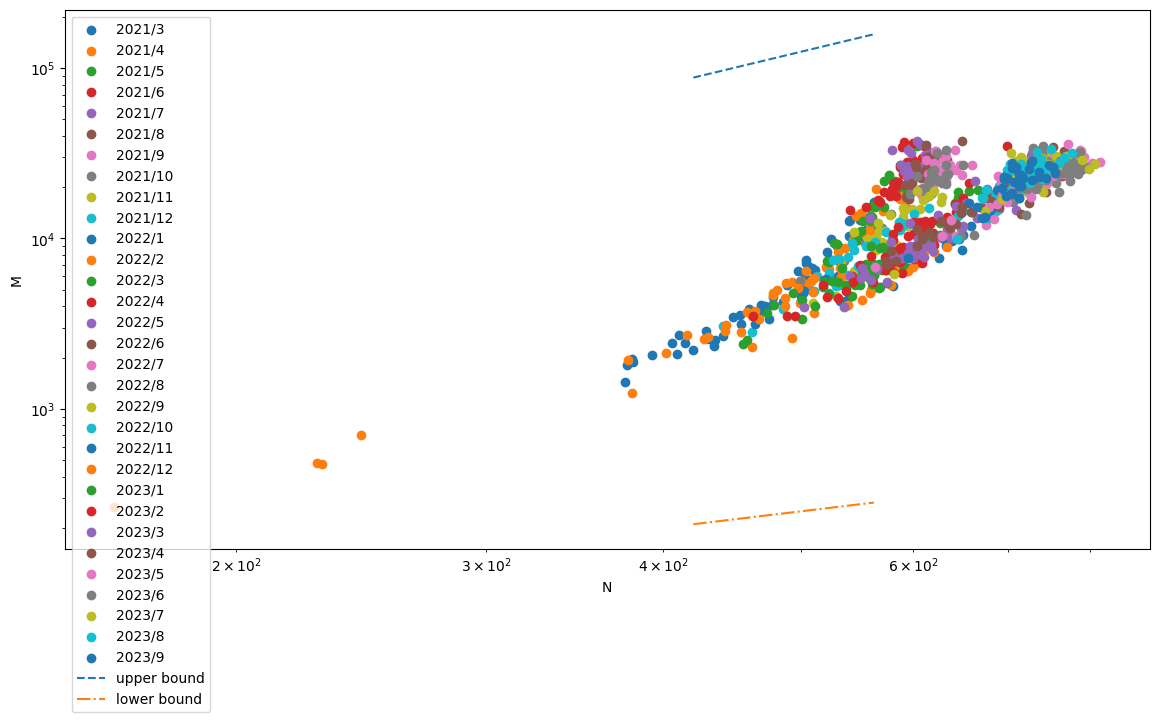

In [121]:
# プロット
nn = len(node_list_p4_1)
xmin = min(node_list_p4_1)
xmax = max(node_list_p4_1)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(node_list_p4_1, edge_list_p4_1, label='2021/3')
plt.scatter(node_list_p4_2, edge_list_p4_2, label='2021/4')
plt.scatter(node_list_p4_3, edge_list_p4_3, label='2021/5')
plt.scatter(node_list_p4_4, edge_list_p4_4, label='2021/6')
plt.scatter(node_list_p4_5, edge_list_p4_5, label='2021/7')
plt.scatter(node_list_p4_6, edge_list_p4_6, label='2021/8')
plt.scatter(node_list_p4_7, edge_list_p4_7, label='2021/9')
plt.scatter(node_list_p4_8, edge_list_p4_8, label='2021/10')
plt.scatter(node_list_p4_9, edge_list_p4_9, label='2021/11')
plt.scatter(node_list_p4_10, edge_list_p4_10, label='2021/12')
plt.scatter(node_list_p4_11, edge_list_p4_11, label='2022/1')
plt.scatter(node_list_p4_12, edge_list_p4_12, label='2022/2')
plt.scatter(node_list_p4_13, edge_list_p4_13, label='2022/3')
plt.scatter(node_list_p4_14, edge_list_p4_14, label='2022/4')
plt.scatter(node_list_p4_15, edge_list_p4_15, label='2022/5')
plt.scatter(node_list_p4_16, edge_list_p4_16, label='2022/6')
plt.scatter(node_list_p4_17, edge_list_p4_17, label='2022/7')
plt.scatter(node_list_p4_18, edge_list_p4_18, label='2022/8')
plt.scatter(node_list_p4_19, edge_list_p4_19, label='2022/9')
plt.scatter(node_list_p4_20, edge_list_p4_20, label='2022/10')
plt.scatter(node_list_p4_21, edge_list_p4_21, label='2022/11')
plt.scatter(node_list_p4_22, edge_list_p4_22, label='2022/12')
plt.scatter(node_list_p4_23, edge_list_p4_23, label='2023/1')
plt.scatter(node_list_p4_24, edge_list_p4_24, label='2023/2')
plt.scatter(node_list_p4_25, edge_list_p4_25, label='2023/3')
plt.scatter(node_list_p4_26, edge_list_p4_26, label='2023/4')
plt.scatter(node_list_p4_27, edge_list_p4_27, label='2023/5')
plt.scatter(node_list_p4_28, edge_list_p4_28, label='2023/6')
plt.scatter(node_list_p4_29, edge_list_p4_29, label='2023/7')
plt.scatter(node_list_p4_30, edge_list_p4_30, label='2023/8')
plt.scatter(node_list_p4_31, edge_list_p4_31, label='2023/9')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [130]:
# 季節に分けてプロットする
# 12月~2月のデータセット
df_winter = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')]

# 3月~5月のデータセット
df_spring = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2021-06-01')]

# 6月~8月のデータセット
df_summer = df[(df['started_at'] >= '2021-06-01') & (df['started_at'] < '2021-09-01')]

# 9月~11月のデータセット
df_autumn = df[(df['started_at'] >= '2021-09-01') & (df['started_at'] < '2021-12-01')]

# まとめる
df_season = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-12-01')]
df_season.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
2979080,41.888716,-87.644448,TA1306000003,Desplaines St & Kinzie St,2020-12-27 12:55:06,member,70B6A9A437D4C30D,classic_bike,41.877726,-87.654787,13157,Aberdeen St & Jackson Blvd,2020-12-27 12:44:29,1.492156,"(41.87772613, -87.65478743)","(41.888716036, -87.6444478533)"
2979081,41.910000,-87.700000,NaN,NaN,2020-12-18 17:44:19,member,158A465D4E74C54A,electric_bike,41.930000,-87.700000,NaN,NaN,2020-12-18 17:37:15,2.221435,"(41.93, -87.7)","(41.91, -87.7)"
2979082,41.930000,-87.700000,NaN,NaN,2020-12-15 15:11:28,member,5262016E0F1F2F9A,electric_bike,41.910000,-87.690000,NaN,NaN,2020-12-15 15:04:33,2.371269,"(41.91, -87.69)","(41.93, -87.7)"
2979083,41.910000,-87.700000,NaN,NaN,2020-12-15 16:00:11,member,BE119628E44F871E,electric_bike,41.920000,-87.700000,NaN,NaN,2020-12-15 15:54:18,1.110716,"(41.92, -87.7)","(41.91, -87.7)"
2979084,41.800000,-87.590000,NaN,NaN,2020-12-22 12:10:59,member,69AF78D57854E110,electric_bike,41.800000,-87.590000,NaN,NaN,2020-12-22 12:08:17,0.000000,"(41.8, -87.59)","(41.8, -87.59)"


In [131]:
# 12月~2月のデータセットをノード数とエッジ数に変換
node_list_winter, edge_list_winter, timestamp_winter = return_nm(df_winter)

# 3月~5月のデータセットをノード数とエッジ数に変換
node_list_spring, edge_list_spring, timestamp_spring = return_nm(df_spring)

# 6月~8月のデータセットをノード数とエッジ数に変換
node_list_summer, edge_list_summer, timestamp_summer = return_nm(df_summer)

# 9月~11月のデータセットをノード数とエッジ数に変換
node_list_autumn, edge_list_autumn, timestamp_autumn = return_nm(df_autumn)

# まとめる
node_list_season, edge_list_season, timestamp_season = return_nm(df_season)

In [158]:
# 初期値を探す for model1
# 初期値の範囲を設定
init_m0_range = [1, 10000]
init_kappa_range = [0.001, 1]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_season, node_list_season, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = active_node_list - model1(edge_list_season, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]


[3.83210875e+03 9.73766883e-02]


In [159]:
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [2, 40000]
init_Np_range = [1, 1000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model1, edge_list_season, node_list_season, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = active_node_list - model2(edge_list_season, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[32404.57486366   609.63968457]


In [160]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list_season,node_list_season,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list_season)):
    Np.append((1+np.sqrt(1+32*edge_list_season[i]/kappa))/2)


for i in range(len(node_list_season)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_season)):
    M_fit.append(calc_M(Np[i], kappa))



N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, edge_list_season, node_list_season, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_list_season)):
    kappa2.append(8*edge_list_season[i]/(Np2**2-Np2))

for i in range(len(node_list_season)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_season)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model1:  [3.83210875e+03 9.73766883e-02]
model2:  [2862.1286483   569.31268785]


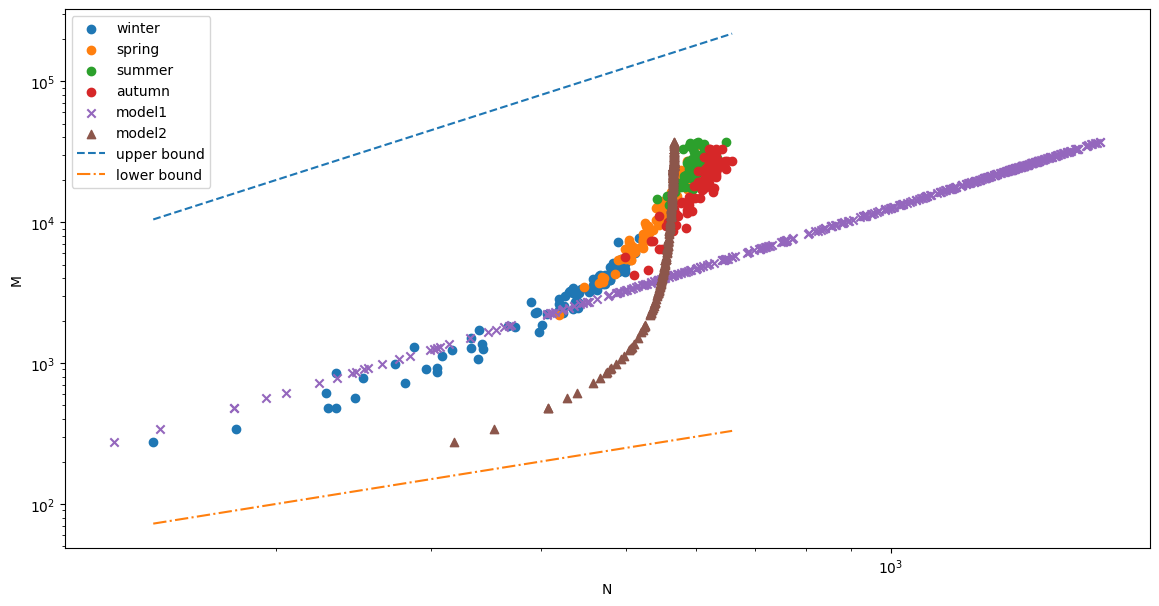

In [161]:
# プロット
nn = len(node_list_season)
xmin = min(node_list_season)
xmax = max(node_list_season)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(node_list_winter, edge_list_winter, label='winter')
plt.scatter(node_list_spring, edge_list_spring, label='spring')
plt.scatter(node_list_summer, edge_list_summer, label='summer')
plt.scatter(node_list_autumn, edge_list_autumn, label='autumn')
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()